In [ ]:
# Add to top
import os
import pandas as pd
from datetime import datetime

ELO_FILE = 'tmp/team_elo_ratings.csv'

# Initialize parameters
BASE_RATING = 1500
K_FACTOR = 32  # Increased for college basketball context
HOME_ADVANTAGE = 70  # Elo points for home court
MOV_MULTIPLIER = 1.1  # Margin of Victory scaling


# Load data (replace with actual path)
game_data = pd.read_csv('games_2022.csv').sort_values('game_date')
teams_regions = pd.read_csv('Team Region Groups.csv')

# Add east teams to teams_regions
east_region_games = pd.read_csv('East Regional Games to predict.csv')
# east_region_games has columns team_home and team_away
# for each team in both columns, add the team to teams_regions with region 'East'
east_teams = pd.concat([east_region_games['team_home'], east_region_games['team_away']]).unique()
east_teams = pd.DataFrame(east_teams, columns=['team'])
east_teams['region'] = 'East'
teams_regions = pd.concat([teams_regions, east_teams], ignore_index=True)


teams_regions = teams_regions.drop_duplicates(subset=['team'])


# Preprocess data
game_data['game_date'] = pd.to_datetime(game_data['game_date'])
game_data = game_data.sort_values('game_date')

# Create Elo tracker
teams = list(set(game_data['team'].unique()).union(set(teams_regions['team'])))
elo = pd.Series([BASE_RATING]*len(teams), index=teams)

# Process each game chronologically
for _, game_group in game_data.groupby('game_id'):
    game = game_group.iloc[0]  # Get first team's perspective
    opp_game = game_group.iloc[1]  # Get opponent's perspective
    
    team = game['team']
    opponent = opp_game['team']
    
    # Get current ratings with home adjustment
    team_elo = elo[team] + (HOME_ADVANTAGE if game['home_away_NS'] == 1 else 0)
    opp_elo = elo[opponent] + (HOME_ADVANTAGE if opp_game['home_away_NS'] == 1 else 0)
    
    # Calculate expected outcome
    expected = 1 / (1 + 10**((opp_elo - team_elo)/400))
    actual = 1 if game['team_score'] > opp_game['team_score'] else 0
    
    # Margin of victory adjustment
    mov = abs(game['team_score'] - opp_game['team_score'])
    mov_mult = (mov**0.8)/(7.5 + 0.006*(abs(team_elo - opp_elo)))
    
    # Update ratings
    k = K_FACTOR * mov_mult * MOV_MULTIPLIER
    
    points_change = k * (actual - expected)
    elo[team] += points_change
    elo[opponent] -= points_change

mean_rating = elo.mean()
offset = mean_rating - BASE_RATING
elo = elo - offset

print(f"Adjusted ratings by {offset:.2f} points to maintain mean of {BASE_RATING}")

# Create a mapping from team to region
team_to_region = teams_regions.set_index('team')['region'].to_dict()

# Generate final Elo ratings with region information
final_elo = elo.to_frame('Rating')
final_elo.index.name = 'Team'

# Add region information where available (without dropping teams)
final_elo['Region'] = final_elo.index.map(team_to_region)

# Sort by rating (descending) and keep all teams
final_elo = final_elo.sort_values('Rating', ascending=False)

# print("Regional Rankings (Top 16 per Region):")
# print(final_elo)

final_elo.to_csv(ELO_FILE)

# print all 3 regions separately with ratings rounded to 0 decimal places and rankings
for region in final_elo['Region'].dropna().unique():
    # if region != 'West':
    #     continue
    df = final_elo[final_elo['Region'] == region].copy()
    df['Rating'] = df['Rating'].round(0).astype(int)
    df['Rank'] = range(1, len(df) + 1)
    print(f"\n{region} Region Rankings:")
    print(df.head(136))


C:\Users\shiva\AppData\Local\Temp\ipykernel_25624\1534026764.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1529.1973241507153' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo[team] += points_change


Adjusted ratings by 0.00 points to maintain mean of 1500

North Region Rankings:
                                 Rating Region  Rank
Team                                                
south_carolina_gamecocks           1907  North     1
florida_gulf_coast_eagles          1885  North     2
stephen_f_austin_ladyjacks         1806  North     3
ucf_knights                        1788  North     4
middle_tennessee_blue_raiders      1755  North     5
lsu_tigers                         1751  North     6
belmont_bruins                     1748  North     7
ole_miss_rebels                    1730  North     8
troy_trojans                       1717  North     9
jackson_state_lady_tigers          1710  North    10
tennessee_lady_volunteers          1689  North    11
south_florida_bulls                1689  North    12
georgia_lady_bulldogs              1684  North    13
stetson_hatters                    1669  North    14
florida_gators                     1661  North    15
louisiana_tech_lad

In [93]:
# import matplotlib.pyplot as plt

# # This code should be added to your ELO implementation
# # Track ELO evolution throughout the season for top teams

# def track_elo_evolution():
#     # Initialize parameters (same as your main code)
#     BASE_RATING = 1500
#     K_FACTOR = 32
#     HOME_ADVANTAGE = 70
#     MOV_MULTIPLIER = 1.1
    
#     # Load data
#     game_data = pd.read_csv('games_2022.csv')
#     game_data['game_date'] = pd.to_datetime(game_data['game_date'])
#     # game_data = game_data.sort_values('game_date')
    
#     # Find the top teams from final rankings to track
#     # top_teams = ['south_carolina_gamecocks', 'stanford_cardinal', 
#     #              'nc_state_wolfpack', 'louisville_cardinals', 
#     #              'baylor_bears', 'uconn_huskies']
    
#     # Get top teams from West region based on final Elo
#     west_teams = final_elo[final_elo['Region'] == 'West'].sort_values('Rating', ascending=False)
#     west_ranks = [1, 4, 7, 10, 13, 15]  # Ranks to select
#     west_ranks_str = ["1st", "4th", "7th", "10th", "13th", "15th"]
#     top_teams = []

#     for rank in west_ranks:
#         if rank <= len(west_teams):
#             team = west_teams.iloc[rank-1].name
#             top_teams.append(team)

#     # Ensure we have teams to track
#     if not top_teams:
#         # Fallback to some known top teams if no West region data
#         top_teams = ['stanford_cardinal', 'oregon_ducks', 
#                      'ucla_bruins', 'arizona_wildcats', 
#                      'colorado_buffaloes', 'washington_state_cougars']
    
#     # Initialize tracking dataframe
#     elo_history = []
    
#     # Create ELO tracker
#     teams = list(set(game_data['team'].unique()))
#     elo = pd.Series([BASE_RATING]*len(teams), index=teams)
    
#     # Process games and track ratings
#     for _, game_group in game_data.groupby('game_id'):
#         game_date = game_group['game_date'].iloc[0]
        
#         # Regular ELO update logic from your code
#         game = game_group.iloc[0]
#         opp_game = game_group.iloc[1]
        
#         team = game['team']
#         opponent = opp_game['team']
        
#         team_elo = elo[team] + (HOME_ADVANTAGE if game['home_away_NS'] == 1 else 0)
#         opp_elo = elo[opponent] + (HOME_ADVANTAGE if opp_game['home_away_NS'] == 1 else 0)
        
#         expected = 1 / (1 + 10**((opp_elo - team_elo)/400))
#         actual = 1 if game['team_score'] > opp_game['team_score'] else 0
        
#         mov = abs(game['team_score'] - opp_game['team_score'])
#         mov_mult = (mov**0.8)/(7.5 + 0.006*(abs(team_elo - opp_elo)))
        
#         k = K_FACTOR * mov_mult * MOV_MULTIPLIER
#         elo[team] += k * (actual - expected)
#         elo[opponent] += k * ((1 - actual) - (1 - expected))
        
#         # Record ELO history for top teams
#         for team_name in top_teams:
#             if team_name in elo:
#                 elo_history.append({
#                     'date': game_date,
#                     'team': team_name,
#                     'elo': elo[team_name]
#                 })
    
#     # Create the visualization
#     elo_df = pd.DataFrame(elo_history)
    
#     # Resample to weekly to reduce noise
#     weekly_elo = []
#     for team in top_teams:
#         team_data = elo_df[elo_df['team'] == team]
#         if len(team_data) > 0:
#             team_data = team_data.set_index('date')
#             team_weekly = team_data.resample('W').last().reset_index()
#             team_weekly['team'] = team
#             weekly_elo.append(team_weekly[2:])
    
#     # weekly_elo = weekly_elo[:, 3:]
    
#     if weekly_elo:
#         weekly_elo_df = pd.concat(weekly_elo)
        
#         plt.figure(figsize=(12, 7))
#         colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
        
#         # Plot each team
#         for i, team in enumerate(top_teams):
#             team_data = weekly_elo_df[weekly_elo_df['team'] == team]
#             if len(team_data) > 0:
#                 plt.plot(team_data['date'], team_data['elo'], 
#                         #  team should be place number and team name (1st 4th 7th 10th 13th 15th)
#                          label=f"{team} ({west_ranks_str[i]})",
#                          linewidth=2.5, color=colors[i % len(colors)])
        
#         plt.title('ELO Rating Evolution of West Region Teams', fontsize=14, fontweight='bold')
#         plt.xlabel('Date')
#         plt.ylabel('ELO Rating')
#         plt.grid(True, alpha=0.3)
#         plt.legend(loc='upper left')
#         plt.tight_layout()
#         plt.savefig('elo_evolution.png', dpi=300)
#         plt.close()
        
#         return "ELO evolution chart created"
#     else:
#         return "Not enough data to create ELO evolution chart"

# # Call the function (add this to your main code where appropriate)
# track_elo_evolution()


In [96]:
# fix df so team is a column and not index
final_elo.reset_index(inplace=True)

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# list plt styles
print(plt.style.available)
# dark background seaborn
plt.style.use('ggplot')

# dpi
plt.rcParams['figure.dpi'] = 300

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'bright', 'cjk-jp-font', 'cjk-kr-font', 'cjk-sc-font', 'cjk-tc-font', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'grid', 'high-contrast', 'high-vis', 'ieee', 'latex-sans', 'light', 'muted', 'nature', 'no-latex', 'notebook', 'pgf', 'retro', 'russian-font', 'sans', 'scatter', 'science', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'std-colors', 'tableau-colorblind10', 'turkish-font', 'vibrant']


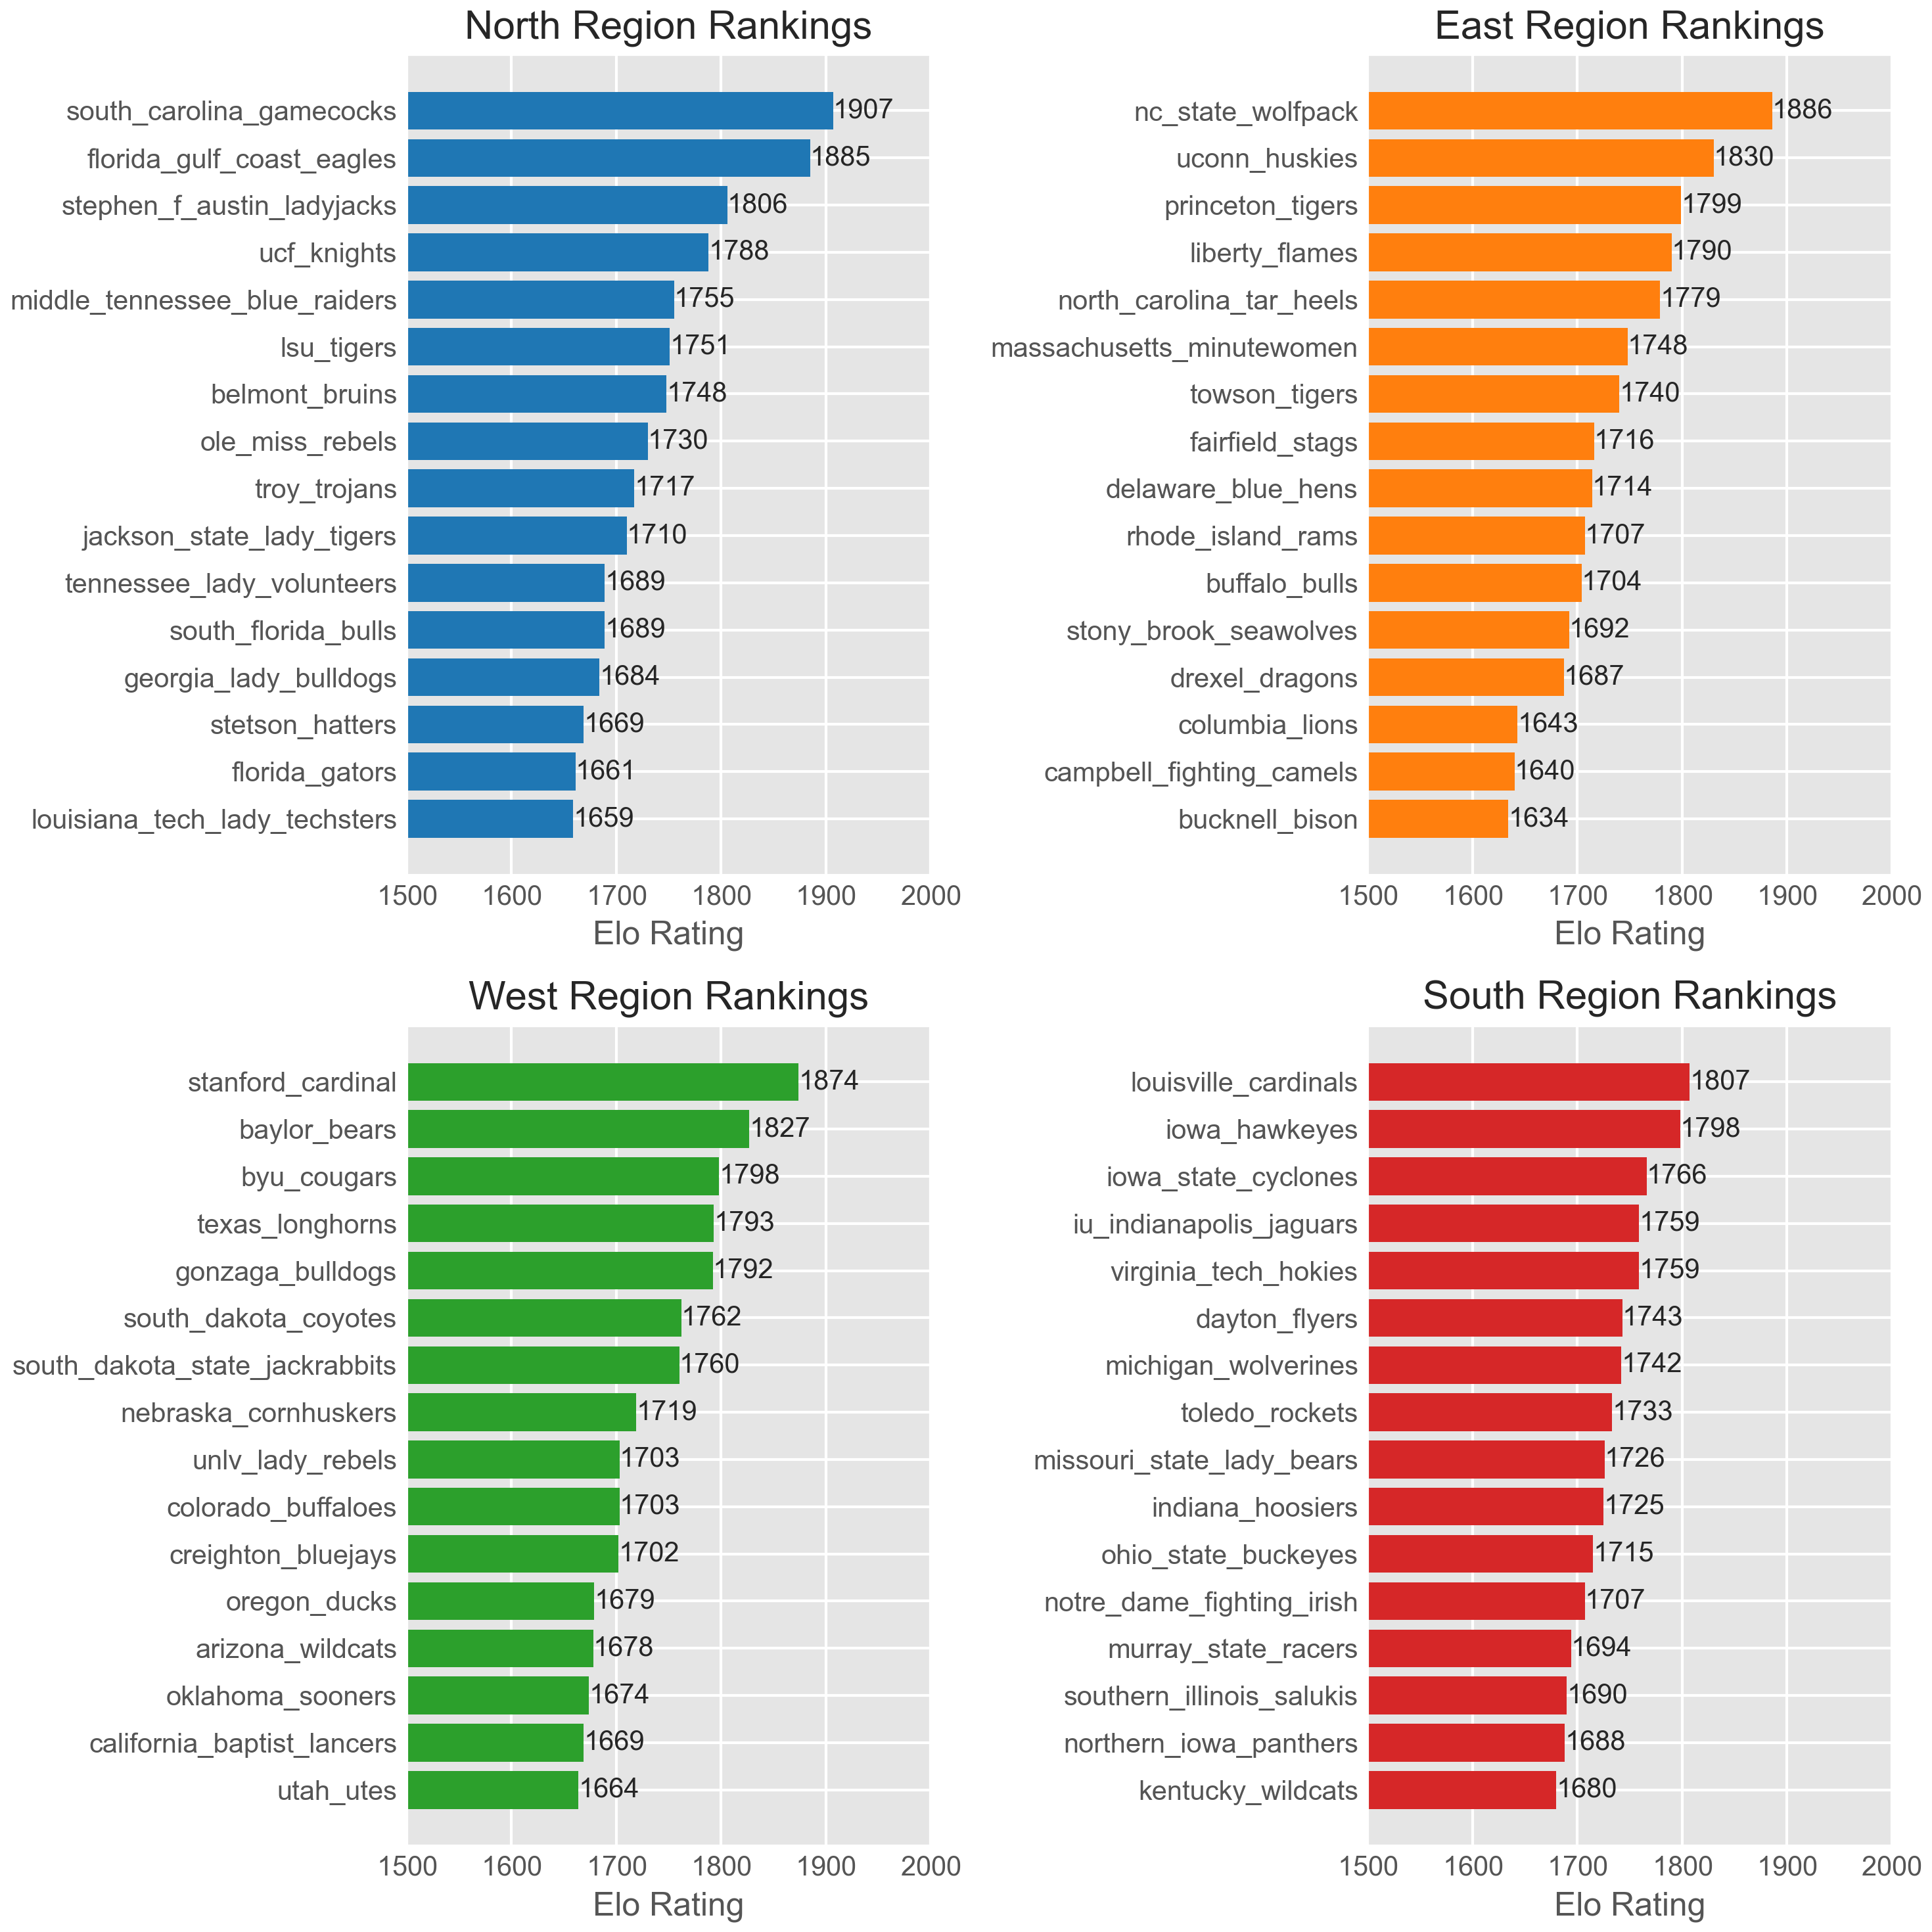

In [117]:
# Make 4 graphs in 4 quadrants ranking top 16 teams in each region
import matplotlib.pyplot as plt
# Define colors for each region
region_colors = {
    'North': '#1f77b4',  # Blue
    'East': '#ff7f0e',   # Orange
    'West': '#2ca02c',   # Green
    'South': '#d62728'   # Red
}
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# fig, axs = plt.subplots(4, 1, figsize=(12, 20))
axs = axs.flatten()

for i, region in enumerate(final_elo['Region'].dropna().unique()):
    df = final_elo[final_elo['Region'] == region].copy()
    df['Rating'] = df['Rating'].round(0).astype(int)
    df['Rank'] = range(1, len(df) + 1)
    # Use only top 16 teams
    df = df.head(16)
    # Plot horizontal bars
    axs[i].barh(df['Team'], df['Rating'], color=region_colors[region])
    axs[i].set_title(f"{region} Region Rankings")
    axs[i].set_xlabel('Elo Rating')
    axs[i].invert_yaxis()  # Highest rating on top
    # start x at 1200 not 0
    axs[i].set_xlim(1500, 2000)
    for index, value in enumerate(df['Rating']):
        axs[i].text(value, index, str(value), va='center')
        if index >= 16 - 1:
            break

plt.tight_layout()
plt.savefig('tmp/elo_rankings.png')

In [ ]:
import seaborn as sns

# Make 4 graphs in 4 quadrants ranking top 16 teams in each region
import matplotlib.pyplot as plt



fig, axs = plt.subplots(2, 2, figsize=(14, 12))
axs = axs.flatten()

for i, region in enumerate(final_elo['Region'].dropna().unique()):
    df = final_elo[final_elo['Region'] == region].copy()
    df['Rating'] = df['Rating'].round(0).astype(int)
    df['Rank'] = range(1, len(df) + 1)
    # Use only top 16 teams
    df = df.head(16)
    
    # Create horizontal bars with region-specific color
    bars = axs[i].barh(df['Team'], df['Rating'], color=region_colors[region], alpha=0.8)
    
    # Style the plot
    axs[i].set_title(f"{region} Region Rankings", fontsize=14, fontweight='bold')
    axs[i].set_xlabel('Elo Rating', fontsize=12)
    axs[i].tick_params(axis='y', labelsize=10)
    axs[i].invert_yaxis()  # Highest rating on top
    axs[i].set_xlim(1500, max(df['Rating']) + 50)  # Dynamic upper limit
    axs[i].grid(True, axis='x', alpha=0.3, linestyle='--')
    
    # Add rating values at the end of each bar
    for bar, value in zip(bars, df['Rating']):
        axs[i].text(
            bar.get_width() + 5, 
            bar.get_y() + bar.get_height()/2, 
            str(value), 
            va='center',
            fontweight='bold',
            fontsize=9
        )

# plt.tight_layout()
plt.savefig('tmp/elo_rankings.png', dpi=300, bbox_inches='tight')

In [111]:
elo

Team
mount_olive_trojans              1486.990684
lake_erie_storm                  1463.394971
liberty_flames                   1789.983317
molloy_lions                     1497.130056
nevada_wolf_pack                 1577.646863
                                    ...     
wesleyan_college_ga_wolves       1431.841301
trinity_baptist_eagles           1408.141368
north_dakota_fighting_hawks      1474.273073
coastal_carolina_chanticleers    1637.290650
pacific_tigers                   1344.583576
Length: 564, dtype: float64

In [112]:
elo

Team
mount_olive_trojans              1486.990684
lake_erie_storm                  1463.394971
liberty_flames                   1789.983317
molloy_lions                     1497.130056
nevada_wolf_pack                 1577.646863
                                    ...     
wesleyan_college_ga_wolves       1431.841301
trinity_baptist_eagles           1408.141368
north_dakota_fighting_hawks      1474.273073
coastal_carolina_chanticleers    1637.290650
pacific_tigers                   1344.583576
Length: 564, dtype: float64

In [113]:
final_elo

,Team,Rating,Region
0,south_carolina_gamecocks,1906.800590,North
1,nc_state_wolfpack,1885.965602,East
2,florida_gulf_coast_eagles,1884.702512,North
3,stanford_cardinal,1873.577417,West
4,uconn_huskies,1829.847973,East
...,...,...,...
559,hartford_hawks,1200.879218,NaN
560,florida_am_rattlers,1195.810285,NaN
561,delaware_state_hornets,1169.443563,NaN
562,butler_bulldogs,1166.210631,NaN


In [114]:
# ========== PHASE 1b PREDICTIONS ==========
if os.path.exists(ELO_FILE):
    elo_ratings = pd.read_csv(ELO_FILE, index_col='Team')['Rating']
else:
    elo_ratings = final_elo['Rating']  # Fallback to in-memory

# Load East games
east_games = pd.read_csv("East Regional Games to predict.csv")

# Prediction engine with key enhancements
def predict_probability(row):
    team_home = row['team_home']
    team_away = row['team_away']
    
    # Handle missing teams (expansion teams/new programs)
    base_elo = -1
    home_elo = elo_ratings.get(team_home, base_elo) 
    away_elo = elo_ratings.get(team_away, base_elo)
    assert home_elo != -1 and away_elo != -1, f"Missing Elo for {team_home} or {team_away}"
    assert home_elo != away_elo, f"Identical Elo for {team_home} and {team_away}"
    
    # Contextual adjustments (key competitive edge)
    rest_advantage = (row['rest_days_Home'] - row['rest_days_Away']) * 7.2  # 1 day ≈ 7 Elo pts
    travel_penalty = (row['travel_dist_Away']/300) * -2.8  # -2.8 per 300 miles
    
    # Neutral site adjustment (home_away_NS=0 removes 70% of home advantage)
    neutral_site_adj = 0 if row['home_away_NS'] == 0 else (70 * row['home_away_NS'])
    
    final_diff = (home_elo - away_elo) + rest_advantage + travel_penalty + neutral_site_adj
    
    print(f"Predicting: {team_home} vs {team_away} | Home Elo: {home_elo}, Away Elo: {away_elo} | Final Diff: {final_diff}")
    return round(1 / (1 + 10 ** (-final_diff/400)), 4)

# Generate predictions
east_games['WINNING %'] = east_games.apply(predict_probability, axis=1)

# Submission safeguards
east_games['WINNING %'] = east_games['WINNING %'].clip(0.01, 0.99)  # Force reasonable probs
# east_games.to_csv('phase1b_submission.csv', index=False)

print("\nPhase 1b Predictions:")
print(east_games[['game_id', 'team_home', 'team_away', 'WINNING %']])


Predicting: rhode_island_rams vs north_carolina_tar_heels | Home Elo: 1706.8790978263107, Away Elo: 1779.3138283994608 | Final Diff: -43.62139723981676
Predicting: nc_state_wolfpack vs rhode_island_rams | Home Elo: 1885.965601738924, Away Elo: 1706.8790978263107 | Final Diff: 222.28650391261334
Predicting: nc_state_wolfpack vs north_carolina_tar_heels | Home Elo: 1885.965601738924, Away Elo: 1779.3138283994608 | Final Diff: 142.66510667279658
Predicting: liberty_flames vs bucknell_bison | Home Elo: 1789.9833170542065, Away Elo: 1634.456966825314 | Final Diff: 131.59301689555906
Predicting: drexel_dragons vs delaware_blue_hens | Home Elo: 1687.3511997453822, Away Elo: 1714.1783853062632 | Final Diff: -18.7738522275476
Predicting: massachusetts_minutewomen vs princeton_tigers | Home Elo: 1747.9405967072562, Away Elo: 1798.7711209724378 | Final Diff: -36.7478575985149
Predicting: buffalo_bulls vs stony_brook_seawolves | Home Elo: 1704.427438979577, Away Elo: 1692.4037255462715 | Final Dif

In [115]:
# After predictions
assert not east_games['WINNING %'].isnull().any(), "Missing probabilities!"
assert east_games['WINNING %'].between(0,1).all(), "Invalid probability range!"

# Sample check for known matchup
nc_state = elo_ratings.get('nc_state_wolfpack', 1500)
print(f"\nNC State Elo: {nc_state:.0f} (Should be 1800+ if top seed)")
print(f"G_East_2 Prediction: {east_games.loc[1, 'WINNING %']} (Expect >0.75 for 1v16)")



NC State Elo: 1886 (Should be 1800+ if top seed)
G_East_2 Prediction: 0.7824 (Expect >0.75 for 1v16)
